In [2]:
def estimate_return_level(quantile,loc,scale,shape):
    level = loc + scale / shape * (1 - (-np.log(quantile))**(shape))
    return level

def estimate_return_level_period(period,loc,scale,shape):
    '''
    Compute GEV-based return level for a given return period, and GEV parameters
    '''
    return gev.ppf(1-1/period,shape,loc=loc,scale=scale)

def empirical_return_level(data):
    '''
    Compute empirical return level using the algorithm introduced in Tutorial 2
    '''
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df['sorted'] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df['ranks_sp'] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df['exceedance'] = df['ranks_sp']/(n+1)
    # find return period
    df['period'] = 1 / df['exceedance']

    df = df[::-1]

    out = xr.DataArray(
        dims=['period'],
        coords={'period':df['period']},
        data=df['sorted'],name='level')
    return out

def fit_return_levels(data,years,N_boot=None,alpha=0.05):
    '''
    Fit GEV to data, compute return levels and confidence intervals
    '''
    empirical = empirical_return_level(data).rename({'period':'period_emp'}).rename('empirical')
    shape, loc, scale = gev.fit(data,0)
    print('Location: %.1e, scale: %.1e, shape: %.1e' % (loc, scale, shape))
    central = estimate_return_level_period(years,loc,scale,shape)

    out = xr.Dataset(
        # dims = ['period'],
        coords = {
            'period': years,
            'period_emp': empirical['period_emp']
            },
        data_vars={
            'empirical':(['period_emp'],empirical.data),
            'GEV':(['period'],central)
            }
    )

    if N_boot:
        levels = []
        shapes, locs, scales = [],[],[]
        for i in range(N_boot):
            datai = np.random.choice(data,size=data.size,replace=True)
            # print(datai.mean())
            shapei,loci,scalei = gev.fit(datai,0)
            shapes.append(shapei)
            locs.append(loci)
            scales.append(scalei)
            leveli = estimate_return_level_period(years,loci,scalei,shapei)
            levels.append(
                leveli
            )

        levels = np.array(levels)
        quant = alpha / 2, 1-alpha/2
        quantiles = np.quantile(levels,quant,axis=0)

        print('')
        print('Ranges with alpha = %.3f :' % alpha)
        print('Location: [%.2f , %.2f]'  % tuple(np.quantile(locs,quant).tolist()))
        print('Scale: [%.2f , %.2f]'  % tuple(np.quantile(scales,quant).tolist()))
        print('Shape: [%.2f , %.2f]'  % tuple(np.quantile(shapes,quant).tolist()))

        quantiles = xr.DataArray(
            dims=['period','quantiles'],
            coords={'period':out.period,'quantiles':np.array(quant)},
            data=quantiles.T
        )
        out['range'] = quantiles
    return out

def plot_return_levels(obj,c='C0',label='',ax=None):
    '''
    Plot fitted data:
        - empirical return level
        - GEV-fitted return level
        - alpha-confidence ranges with bootstrapping (if N_boot is given)
    '''
    if not ax:
        ax = plt.gca()
    obj['GEV'].plot.line('%s-' % c,lw=3,_labels=False,label=label,ax=ax)
    obj['empirical'].plot.line('%so' % c,mec='k',markersize=5,_labels=False,ax=ax)
    if 'range' in obj:
        # obj['range'].plot.line('k--',hue='quantiles',label=obj['quantiles'].values)
        ax.fill_between(obj['period'],*obj['range'].T,alpha=0.3,lw=0,color=c) 
    ax.semilogx()
    # ax.legend()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.stats import genextreme as gev
import pooch
import os
import tempfile
#mport gev_functions as gf
#import extremes_functions as ef
#import sdfc_classes as sd

In [4]:
icebergs = pd.read_csv('largest_annual_iceberg_NICBYU_manual_validation.csv')

In [5]:
icebergs.head(5)

,Year,File_Name,Date,Max_Size_1,Max_Size_2,Area,Year.1
0,1976.0,d01.csv,1976-02-01,24.0,17.0,1399.400832,1976.0
1,1977.0,d03.csv,1977-12-04,20.0,15.0,1028.971200,1977.0
2,1978.0,a01.csv,1978-10-22,45.0,25.0,3858.642000,1978.0
3,1979.0,c01.csv,1979-09-02,15.0,40.0,2057.942400,1979.0
4,1980.0,a14.csv,1980-12-14,30.0,20.0,2057.942400,1980.0


In [6]:
area = icebergs.Area
year = icebergs.Year

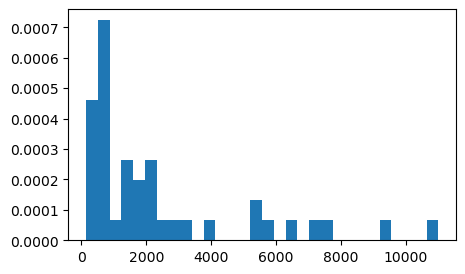

In [7]:
plt.figure(figsize=(5,3))
plt.hist(area, bins=30, density=True)
plt.show()

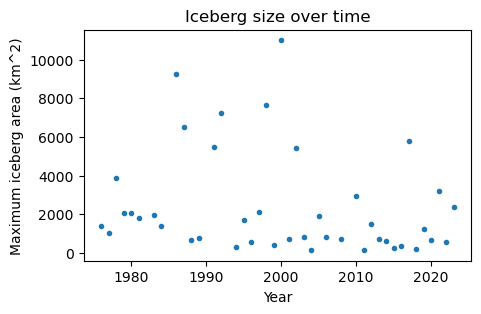

In [8]:
fig = plt.figure(figsize=(5,3))
plt.scatter(year, area, marker='.')
plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (km^2)')
plt.title('Iceberg size over time')
plt.show()

In [9]:
fig.savefig('year_vs_iceberg_size.jpg', dpi=300, bbox_inches = "tight")

In [10]:
area = area.dropna()

In [11]:
area.shape

(42,)

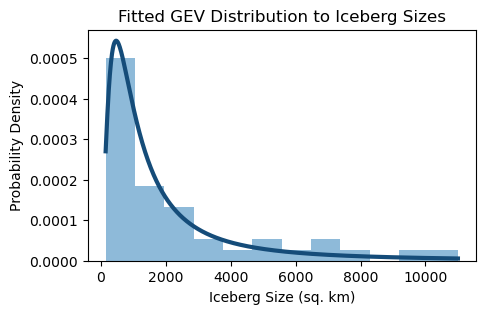

In [12]:
# Fit a GEV distribution to the data
params = gev.fit(area, loc = 1031, scale = 1162)

# Generate some values from the fitted GEV distribution
x = np.linspace(min(area), max(area), 1000)
pdf_fitted = stats.genextreme.pdf(x, *params)

# Plot the histogram of the data and the fitted GEV distribution
fig = plt.figure(figsize=(5,3))
plt.hist(area, bins=12, density=True, alpha=0.5)
plt.plot(x, pdf_fitted, '-', color= '#154c79', lw=3)
plt.xlabel('Iceberg Size (sq. km)')
plt.ylabel('Probability Density')
plt.title('Fitted GEV Distribution to Iceberg Sizes')
plt.show()

In [13]:
fig.savefig('gev_fit.jpg', dpi=300, bbox_inches = "tight")

In [14]:
shape, loc, scale = params

In [15]:
print("shape: {}, loc: {}, scale: {}".format(shape, loc, scale))

shape: -0.7726125477804411, loc: 864.8131899598474, scale: 863.7313036195644


In [16]:
# bootstrap approach with 100 repetitions (N_boot) to quantify uncertainty range
fit = fit_return_levels(area.values, years=np.arange(1.1, 100), N_boot=400, alpha = 0.075)

Location: 8.6e+02, scale: 8.6e+02, shape: -7.7e-01

Ranges with alpha = 0.075 :
Location: [545.71 , 1284.03]
Scale: [545.60 , 1269.79]
Shape: [-1.25 , -0.47]


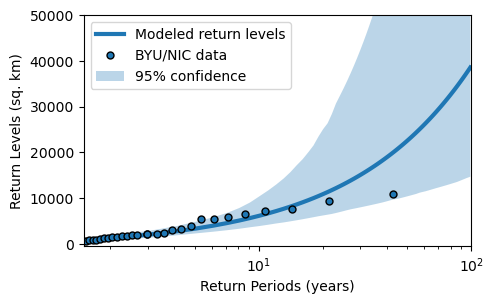

In [17]:
# create figures
fig, ax = plt.subplots(1, 1,figsize=(5,3))
# reduce dimension of axes to have only one index

# create x-data for QQ-plot (top left)
x = np.linspace(0, 1, 100)

# plot return levels 
plot_return_levels(fit, ax=ax)
ax.set_xlim(1.5, 100)
ax.set_ylim(0, 1e5)

# aesthetics
ax.set_xlabel("Return Periods (years)")
ax.set_ylabel("Return Levels (sq. km)")
ax.legend(["Modeled return levels","BYU/NIC data","95% confidence"], loc="upper left")
ax.set_ylim(-5e2, 5e4)
plt.show()

In [18]:
fig.savefig('return_period_confidence.jpg', dpi=300, bbox_inches = "tight")

In [24]:
# X-year of interest
x = 100
print("{}-year return level: {:.2f}".format(x, estimate_return_level_period(x, loc, scale, shape).mean()))

100-year return level: 38827.12


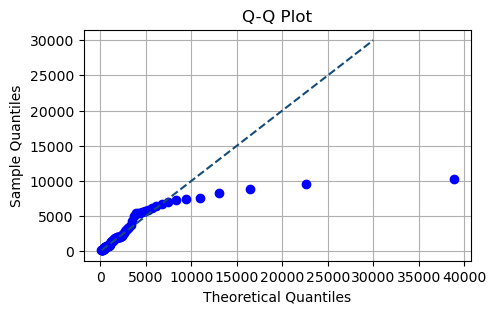

In [25]:
# Generate quantiles from the fitted GEV distribution
fitted_quantiles1 = gev(*params).ppf(np.linspace(0.01, 0.99, 100))

# Generate quantiles from the sample data
data_quantiles1 = np.percentile(area, np.linspace(1, 99, 100))

# Plot the Q-Q plot
fig = plt.figure(figsize=(5,3))
plt.plot(fitted_quantiles1, data_quantiles1, ls="", marker="o", color='b')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')
plt.plot([np.min(area), 3e4], [np.min(area), 3e4], color='#154c79', linestyle='--')
plt.grid(True)
plt.show()

In [21]:
fig.savefig('QQ_plot.jpg', dpi=300, bbox_inches = "tight")

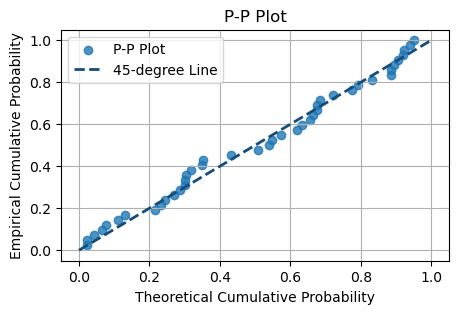

In [28]:

# Create a GEV distribution
gev_dist = gev(c=shape, loc=loc, scale=scale)

# Calculate empirical CDF of the data
sorted_data = np.sort(area)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Calculate theoretical CDF of the GEV distribution
theoretical_cdf = gev_dist.cdf(sorted_data)

# Plot the P-P plot
fig = plt.figure(figsize=(5, 3))
plt.scatter(theoretical_cdf, empirical_cdf, label='P-P Plot',alpha=.8)
plt.plot([0, 1], [0, 1],  color='#154c79', linestyle='--',linewidth=2, label='45-degree Line')
plt.xlabel('Theoretical Cumulative Probability')
plt.ylabel('Empirical Cumulative Probability')
plt.title('P-P Plot')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
fig.savefig('PP_plot.jpg', dpi=300, bbox_inches = "tight")

In [33]:
estimate_return_level_period(40, loc, scale, shape).mean()

18887.229706779235

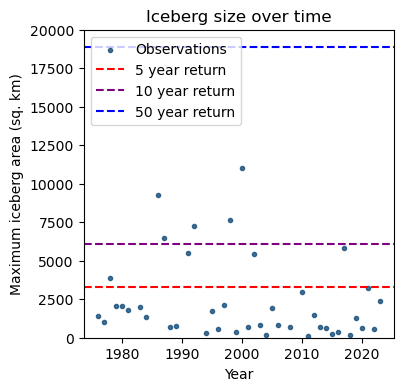

In [45]:
# years of interest
x_years = [10, 50, 100]

fig = plt.figure(figsize=(4,4))
plt.scatter(year, icebergs.Area, marker='.', color='#154c79', label = 'Observations',alpha=0.8)
plt.axhline(y=estimate_return_level_period(5, loc, scale, shape).mean(), color='r', linestyle='--', label='5 year return')
plt.axhline(y=estimate_return_level_period(10, loc, scale, shape).mean(), color='purple', linestyle='--', label='10 year return')  
plt.axhline(y=estimate_return_level_period(40, loc, scale, shape).mean(), color='blue', linestyle='--', label='50 year return')
#plt.axhline(y=gf.estimate_return_level_period(100, loc, scale, shape).mean(), color='b', linestyle='--', label='100 year return')
plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (sq. km)')
plt.title('Iceberg size over time')
plt.ylim(0,2e4)
plt.legend(loc="upper left")
plt.show()

In [46]:
fig.savefig('return_inervals.svg', dpi=300, bbox_inches = "tight")

Add non-stationarity

In [16]:
# instantiate a GEV distribution
law_ns = sd.GEV()

In [17]:
# fit the GEV to the data, while specifying that the location parameter ('loc') is meant
# to be a covariate ('c_') of the time axis (data.index)
for i in range(250):
    law_ns.fit(area.values, c_loc=np.arange(year.size))
    #print(law_ns.coef_)
    # if the first coefficient is not zero, we stop fitting
    if law_ns.coef_[0] != 0:
        print(f'Found non-trivial solution after {i} fitting iterations.')
        print(law_ns.coef_)
        break

Found non-trivial solution after 18 fitting iterations.
[ 1.28079046e+03 -1.77211862e+01  8.32176998e+02  7.43506518e-01]


In [18]:
ef.print_law(law_ns)

+-----------+------------+--------------------+
| GEV (mle) |    Type    |        coef        |
+===========+============+====================+
| loc       | Covariate  | [1280.79, -17.721] |
+-----------+------------+--------------------+
| scale     | Stationary | 832.177            |
+-----------+------------+--------------------+
| shape     | Stationary | 0.744              |
+-----------+------------+--------------------+



In [19]:
df = pd.read_csv('largest_annual_iceberg_NICBYU_manual_validation.csv')

In [20]:
import skextremes as ske

In [21]:
model = ske.models.classic.GEV(area, fit_method = 'lmoments', ci = 0.68, ci_method = 'bootstrap')

(<Figure size 576x432 with 4 Axes>,
 <AxesSubplot: title={'center': 'Density Plot'}, xlabel='x', ylabel='f(x)'>,
 <AxesSubplot: title={'center': 'P-P Plot'}, xlabel='model', ylabel='empirical'>,
 <AxesSubplot: title={'center': 'Q-Q Plot'}, xlabel='model', ylabel='empirical'>,
 <AxesSubplot: title={'center': 'Return Level Plot'}, xlabel='Return period', ylabel='Return level'>)

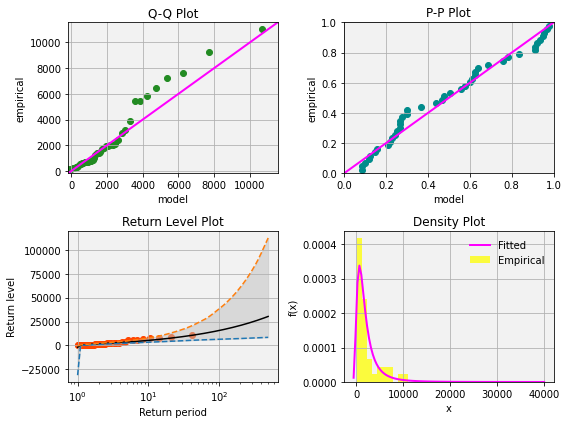

In [22]:
model.plot_summary()

In [23]:
print(model.c, model.loc, model.scale)

-0.3792820362407291 1031.0977266124144 1162.3959322833548


In [24]:
model.params

OrderedDict([('shape', -0.3792820362407291),
             ('location', 1031.0977266124144),
             ('scale', 1162.3959322833548)])

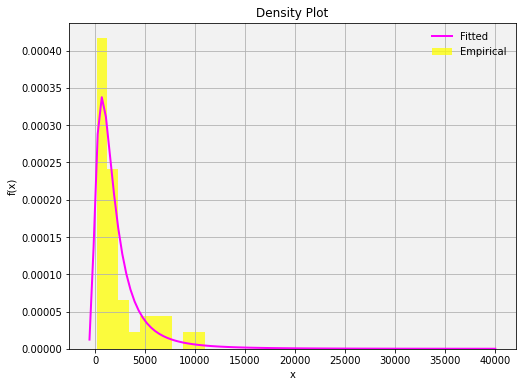

In [25]:
model.plot_density()

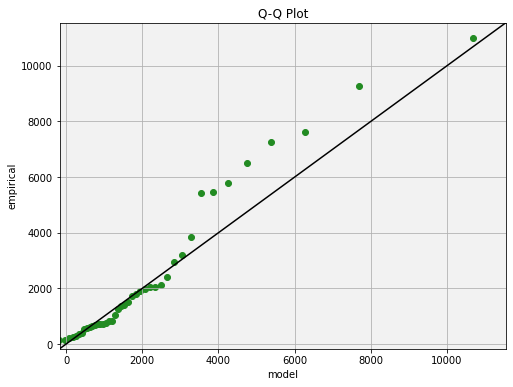

In [26]:
model.plot_qq()

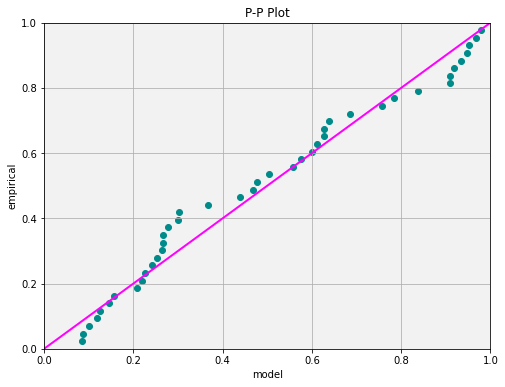

In [27]:
model.plot_pp()

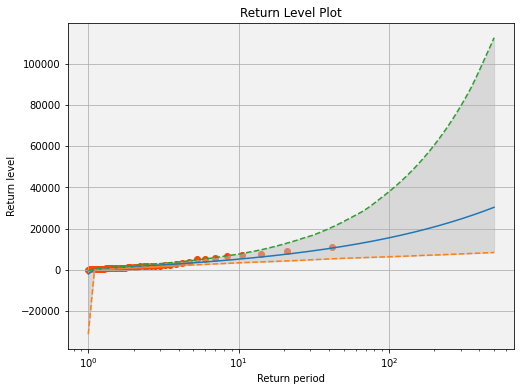

In [28]:
model.plot_return_values()